In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, log_loss, f1_score



In [33]:
def plot_confusion_matrix(y, y_hat):
  from sklearn.metrics import confusion_matrix
  cm=confusion_matrix(y,y_hat)
  sns.heatmap(cm,annot=True)
  plt.xlabel('predicated')
  plt.ylabel('actual')
  plt.title('confusion_matrix')
  plt.xticks(ticks=[0, 1], labels=['Did Not Land', 'Land'])
  plt.yticks(ticks=[0, 1], labels=['Did Not Land', 'Land'])
  plt.show()



In [167]:
data=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv")
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857


Create a landing outcome label from outcome column.

In [88]:
landing_outcomes=data['Outcome'].value_counts()
landing_outcomes

,count
Outcome,
True ASDS,41
None None,19
True RTLS,14
False ASDS,6
True Ocean,5
False Ocean,2
None ASDS,2
False RTLS,1


Anything that starts with True is a successful mission and with false and none is unsuccessful mission.

In [89]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [90]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
landing_class=[]
for outcome in data['Outcome']:
  if outcome in bad_outcomes:
    landing_class.append(0)
  else:
    landing_class.append(1)
data['Class']=landing_class
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


EDA and Preparing data Feature Engineering.

Now let's do some data analysis:
looking at the FlightNumber indicating the continous launch attempts and varaibales that would affect the launch outcome.

Payload vs FlightNumber

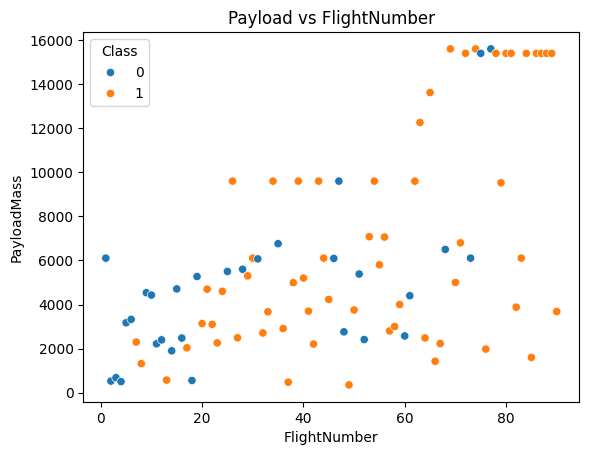

In [38]:
sns.scatterplot(x='FlightNumber', y= 'PayloadMass',hue='Class', data= data )
plt.xlabel('FlightNumber')
plt.ylabel('PayloadMass')
plt.title('Payload vs FlightNumber')
plt.show()

The plot shows as the flightnumber increases, the first stage is more likely to land successfully. Looking at the payload mass as it increases, the less likely the first stage to land successfully.

Compare the success rates of different launch sites.

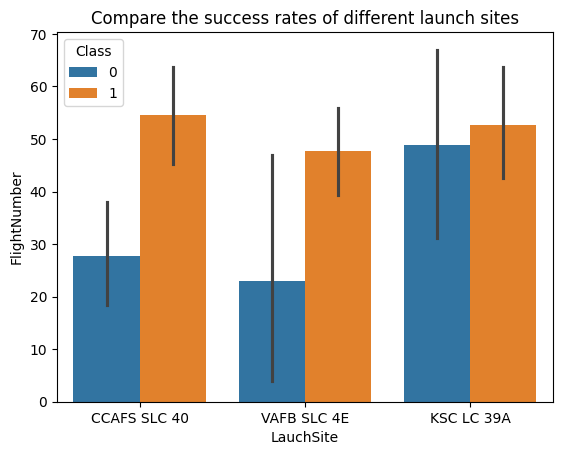

In [39]:
sns.barplot(x='LaunchSite', y='FlightNumber', hue='Class', data =data)
plt.xlabel('LauchSite')
plt.ylabel('FlightNumber')
plt.title('Compare the success rates of different launch sites')
plt.show()


There is a major difference in the success rate of these launch sites. The VAFB SLC 4E has the lowest faliur of landing.

The relationship between playloadMass and LaunchSites

Text(0.5, 1.0, 'The relationship between Payload and launch site')

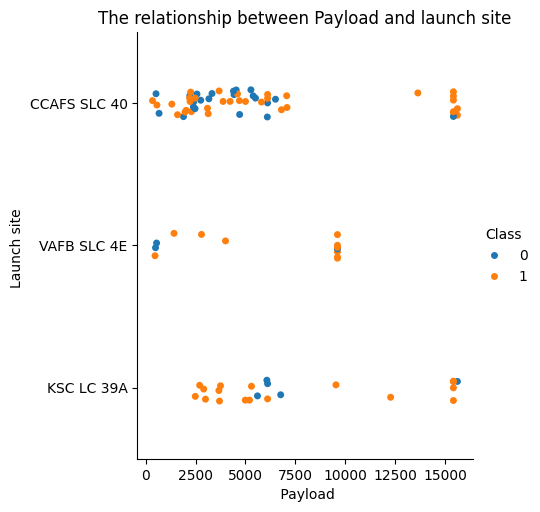

In [40]:
sns.catplot(x='PayloadMass', y='LaunchSite',hue='Class', data=data)
plt.xlabel(' Payload')
plt.ylabel('Launch site ')
plt.title('The relationship between Payload and launch site')


observed form the data Payload Vs. Launch Site scatter point chart we see  for the VAFB-SLC launchsite there are no rockets launched for heavypayload mass(greater than 10000).

The success rate sof each orbits.

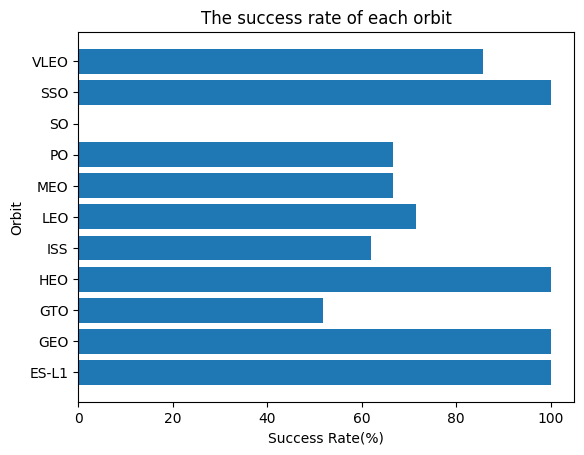

In [24]:
success_rate= data.groupby(['Orbit'])['Class'].mean()*100
orbit_success=pd.DataFrame(success_rate).reset_index()
orbit_success.columns=['orbit', 'success_rate']
orbit_success.head()
plt.barh(orbit_success['orbit'], orbit_success['success_rate'])
plt.xlabel('Success Rate(%)')
plt.ylabel('Orbit')
plt.title('The success rate of each orbit')
plt.show()



Four of the given orbits have a 100 % success rate. The orbit SO has 0% success rate.

The relationship between flight number and orbit type.

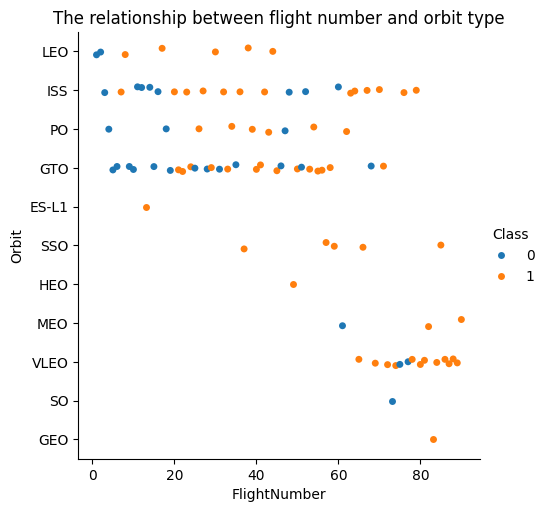

In [25]:
sns.catplot(x='FlightNumber', y='Orbit', hue='Class', data=data)
plt.xlabel('FlightNumber')
plt.ylabel('Orbit')
plt.title('The relationship between flight number and orbit type')
plt.show()

Looking at the LEO orbit the success appears to be related to the flight number; on the other hand, there seems the flight number has no raltionship with orbit type when in orbit GTO.

Text(0.5, 1.0, 'The relationship between Payload and Orbit')

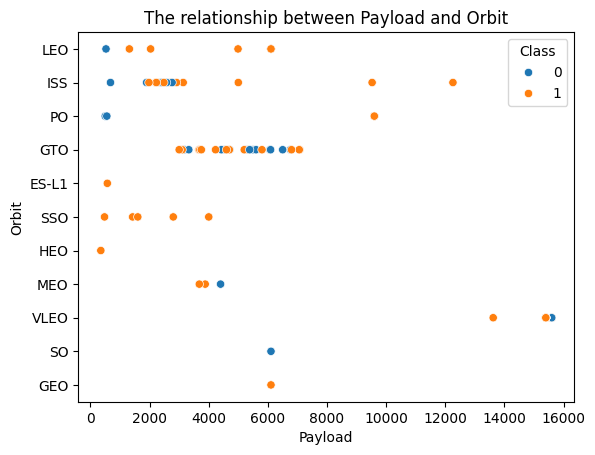

In [27]:
sns.scatterplot(x='PayloadMass', y='Orbit',hue= 'Class', data=data)
plt.xlabel('Payload')
plt.ylabel('Orbit')
plt.title('The relationship between Payload and Orbit')

When looking at the orbits LEO and ISS there are successful landings with heavy playloads. But for GTO it is hard to distinguish since there are both successful and failed missions around the same payload.

In [11]:
year=[]
for i in data['Date']:
  year.append(i.split("-")[0])
data['Date']=year

data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


Find the annual landing success rate.

In [12]:
success_rate=data.groupby(['Date'])['Class'].mean()*100
year_success=pd.DataFrame(success_rate).reset_index()
year_success.columns=['year', 'success_rate']
year_success.head()

,year,success_rate
0,2010,0.000000
1,2012,0.000000
2,2013,0.000000
3,2014,33.333333
4,2015,33.333333


Text(0.5, 1.0, 'The annual landing success rate')

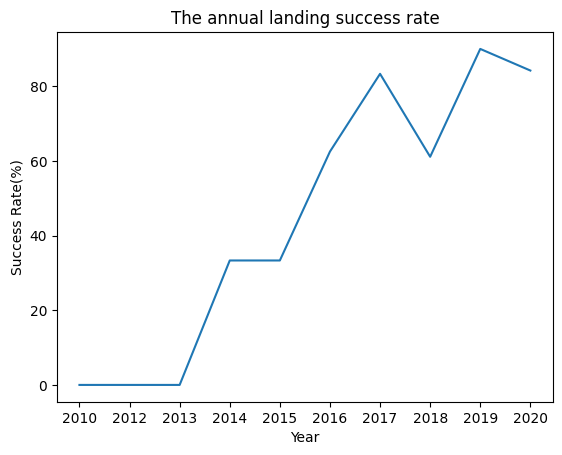

In [15]:
sns.lineplot(x='year', y= 'success_rate', data=year_success)
plt.xlabel('Year')
plt.ylabel('Success Rate(%)')
plt.title('The annual landing success rate')

This graph shows there is a consistent increase in the landing success rate of the Falcon 9 throughout the years.

Prepare the data for model traning.

1, dealing with missing data.

2, convert all categorical data to numeric data using encoders.

3, scaling features

In [16]:
data.isnull().sum()

,0
FlightNumber,0
Date,0
BoosterVersion,0
PayloadMass,0
Orbit,0
LaunchSite,0
Outcome,0
Flights,0
GridFins,0
Reused,0


I will drop the landing pad column all values are the same and it is numerical value.

In [13]:
data.drop(['LandingPad'], axis=1, inplace=True)

In [91]:
data.dtypes

,0
FlightNumber,int64
Date,object
BoosterVersion,object
PayloadMass,float64
Orbit,object
LaunchSite,object
Outcome,object
Flights,int64
GridFins,bool
Reused,bool


In [177]:
from sklearn.preprocessing import OneHotEncoder
OHE=OneHotEncoder(sparse_output=False, drop='first')
for cols in data.columns:
  if data[cols].dtype in ['object', 'bool']:
    transformed_cols=OHE.fit_transform(data[[cols]])
    transformed_cols=pd.DataFrame(transformed_cols, columns=OHE.get_feature_names_out())
    data.drop(cols, axis=1, inplace=True)
    data=pd.concat([data, transformed_cols], axis=1)
data.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Longitude,Latitude,Date_2012-05-22,Date_2013-03-01,Date_2013-09-29,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6104.959412,1,1.0,0,-80.577366,28.561857,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,525.000000,1,1.0,0,-80.577366,28.561857,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,677.000000,1,1.0,0,-80.577366,28.561857,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,500.000000,1,1.0,0,-120.610829,34.632093,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,3170.000000,1,1.0,0,-80.577366,28.561857,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
data.columns

Index(['FlightNumber', 'PayloadMass', 'Flights', 'Block', 'ReusedCount',
       'Longitude', 'Latitude', 'Date_2012-05-22', 'Date_2013-03-01',
       'Date_2013-09-29',
       ...
       'Serial_B1048', 'Serial_B1049', 'Serial_B1050', 'Serial_B1051',
       'Serial_B1054', 'Serial_B1056', 'Serial_B1058', 'Serial_B1059',
       'Serial_B1060', 'Serial_B1062'],
      dtype='object', length=175)

In [95]:
data.dtypes

,0
FlightNumber,int64
PayloadMass,float64
Flights,int64
Block,float64
ReusedCount,int64
...,...
Serial_B1056,float64
Serial_B1058,float64
Serial_B1059,float64
Serial_B1060,float64


build models and train

In [96]:
features, target= data.drop(['Class'], axis=1), data['Class']

In [97]:
train_x, test_x, train_y,test_y= train_test_split(features, target, test_size=0.2,random_state=42 )

In [140]:
scaler=StandardScaler()
train_x=scaler.fit_transform(train_x)
test_x=scaler.transform(test_x)

Logistic regression

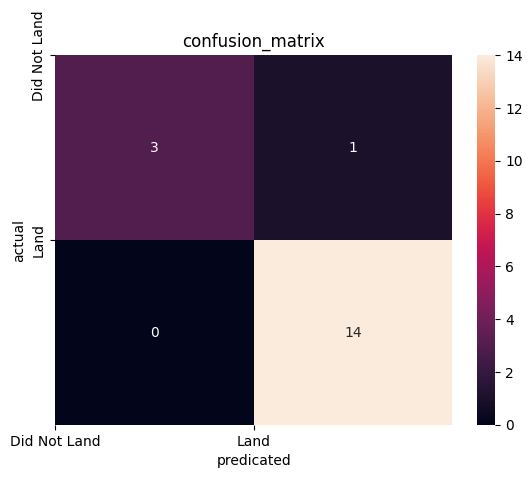

The accuracy is  94.44444444444444 %


In [150]:
param_grid={'C':[0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver':['lbfgs'],'max_iter': [200]}
LR=LogisticRegression()
LR_cv=GridSearchCV(LR, param_grid= param_grid, cv=5 , scoring='accuracy')
LR_cv.fit(train_x, train_y)
LR_cv.best_params_
best_LR = LR_cv.best_estimator_
y_hat=best_LR.predict(test_x)
plot_confusion_matrix(test_y, y_hat)
LR_accuracy=accuracy_score(test_y, y_hat)*100
print('The accuracy is ', LR_accuracy, '%')


Try KNN

{'algorithm': 'auto', 'n_neighbors': 2, 'p': 1}


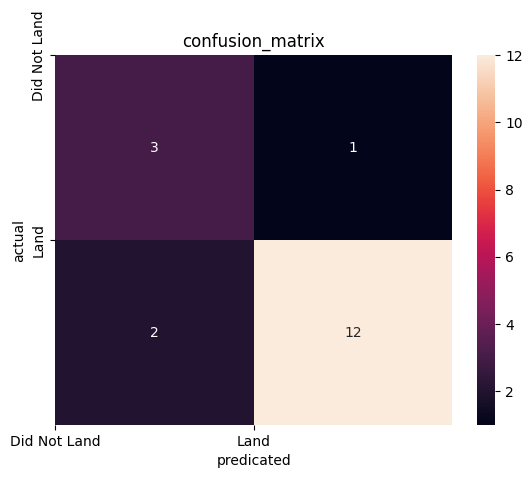

The accuracy is  83.33333333333334 %


In [151]:
param_grid={'n_neighbors': [ 2, 3, 4, 5, 6, 7, 8, 9,10],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1,2]}
KNN=KNeighborsClassifier()
KNN_cv=GridSearchCV(KNN,param_grid=param_grid, cv=5, scoring='accuracy')
KNN_cv.fit(train_x, train_y)
print(KNN_cv.best_params_)
best_KNN=KNN_cv.best_estimator_
y_hat=best_KNN.predict(test_x)
plot_confusion_matrix(test_y, y_hat)
KNN_accuracy=accuracy_score(test_y, y_hat)*100
print('The accuracy is ', KNN_accuracy, '%')


Random Forest accuracy:  88.88888888888889 %


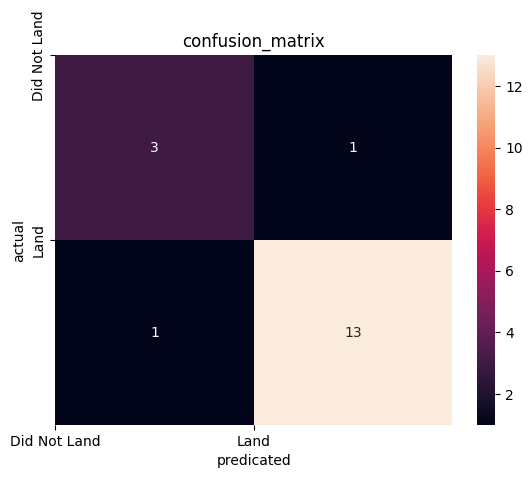

In [163]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_cv = GridSearchCV(estimator=rf, param_grid={'n_estimators': [10, 50, 100]}, cv=5, scoring='accuracy')
rf_cv.fit(train_x, train_y)

rf_best = rf_cv.best_estimator_
yhat_rf = rf_best.predict(test_x)
rf_accuracy = accuracy_score(test_y, yhat_rf) * 100
print('Random Forest accuracy: ', rf_accuracy, '%')
plot_confusion_matrix(test_y, yhat_rf)


In [164]:
accuracy_list={'Logistic Regression': LR_accuracy, 'RFC': rf_accuracy, 'KNN': KNN_accuracy}
accuracy_list=pd.DataFrame(list(accuracy_list.items()), columns=['model', 'accuracy'])
accuracy_list

,model,accuracy
0,Logistic Regression,94.444444
1,RFC,88.888889
2,KNN,83.333333


Text(0.5, 1.0, 'Model Accuracy')

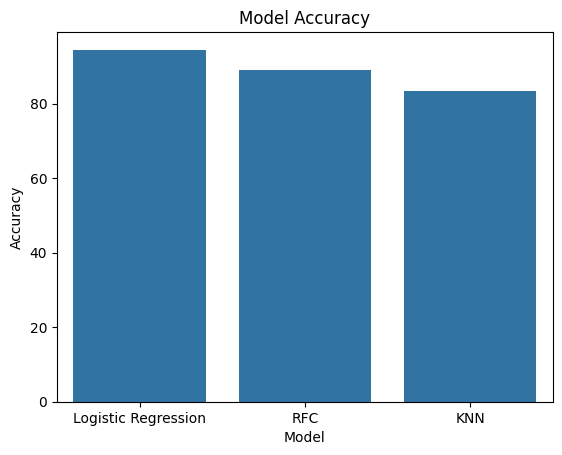

In [165]:
sns.barplot(x='model', y='accuracy', data=accuracy_list)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

Comparing all the giving models, LogistRegression has the highest accuracy of 94.44% and KNNeigbor has the lowest accuracy of 83.33%.

The main objective of this project is to be able to classify  Space X Falcon 9 launch first landing success based on important factors like the orbit, payload mass, flight number and launch sites.  

Using the LogisticRegrssion model we can tell if Space X Falcon launch first landing will be successful or not with 94.4% accuracy.

In [170]:
import joblib
joblib.dump(best_LR, 'model.pkl')


['model.pkl']